In this recipe we'll look at methods for outlier detection. We'll go through an example of outlier detection in a time-series with [Python Outlier Detection](https://pyod.readthedocs.io/en/latest/) (pyOD), a toolbox for outlier detection that implements many state-of-the-art methods and viualization. We'll apply an autoencoder for a similarity-based approach and then an online learning approach for an approach suitable for finding events in streams of data. The streams of data are timeseries of KPIs or CPU performance indicators provided with the [DONUT outlier detector](https://github.com/haowen-xu/donut).

Outlier detection is important in many domains including 
* network security, 
* finance, 
* traffic, 
* social media, 
* machine learning model performance monitoring, or 
* in surveillance.

A host of algorithms have been proposed for outlier detection in these domains. The most prominent algorithms inlude k-Nearest Neighbors (kNN), local outlier factors (LOF), and the isolation forest, and more recently autoencoders, long short-term memory (LSTM), and generative adversarial networks (GANs). 



In [1]:
!wget https://raw.githubusercontent.com/haowen-xu/donut/master/sample_data/cpu4.csv

--2020-09-21 11:32:28--  https://raw.githubusercontent.com/haowen-xu/donut/master/sample_data/cpu4.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.16.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 463050 (452K) [text/plain]
Saving to: ‘cpu4.csv’

cpu4.csv            100%[===================>] 452.20K  --.-KB/s    in 0.1s    

2020-09-21 11:32:28 (4.04 MB/s) - ‘cpu4.csv’ saved [463050/463050]



In [2]:
import pandas as pd

In [3]:
cpu_data = pd.read_csv('cpu4.csv')

In [4]:
cpu_data.head()

,timestamp,value,label
0,1469376000,0.847300,0
1,1469376300,-0.036137,0
2,1469376600,0.074292,0
3,1469376900,0.074292,0
4,1469377200,-0.036137,0


In [5]:
from datetime import datetime


cpu_data['datetime'] = cpu_data.timestamp.astype(int).apply(datetime.fromtimestamp)

In [6]:
cpu_data.head()

,timestamp,value,label,datetime
0,1469376000,0.847300,0,2016-07-24 17:00:00
1,1469376300,-0.036137,0,2016-07-24 17:05:00
2,1469376600,0.074292,0,2016-07-24 17:10:00
3,1469376900,0.074292,0,2016-07-24 17:15:00
4,1469377200,-0.036137,0,2016-07-24 17:20:00


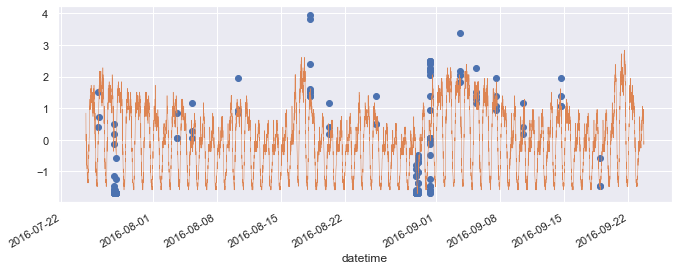

In [7]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

time_data = cpu_data.set_index('datetime')
time_data.loc[time_data['label'] == 1.0, 'value'].plot(linewidth=0.5, marker='o', linestyle='')
time_data.loc[time_data['label'] == 0.0, 'value'].plot(linewidth=0.5)

In [8]:
cpu_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17568 entries, 0 to 17567
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  17568 non-null  int64         
 1   value      17568 non-null  float64       
 2   label      17568 non-null  int64         
 3   datetime   17568 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 549.1 KB


In [9]:
len(cpu_data)

17568

In [10]:
pip install pyOD

     |████████████████████████████████| 96 kB 2.5 MB/s eta 0:00:011
     |████████████████████████████████| 2.1 MB 3.3 MB/s eta 0:00:01
  Created wheel for pyOD: filename=pyod-0.8.3-py3-none-any.whl size=110347 sha256=dea63263c99ff3a51477ca5d0e2b841d158a34236c210496d539f33e3e86c625
  Stored in directory: /Users/ben/Library/Caches/pip/wheels/36/e8/e9/8fb0fbd5ec01e840a6e32ca50329a7638b1aba32aa9d36fbe8
  Created wheel for combo: filename=combo-0.1.1-py3-none-any.whl size=42113 sha256=d02fd1437e6480102d9f7f9e24f6ae775de05608b9d5c71daaa681d693ca8af0
  Stored in directory: /Users/ben/Library/Caches/pip/wheels/66/36/30/c526ec2ea927c0b9ad94aeccd4f5820d258a1dc0b85953913f
  Created wheel for suod: filename=suod-0.0.4-py3-none-any.whl size=2167157 sha256=85b4bfe7bda817cdcda108caeba5b19dfc61457fa7891f9e009f7635ee8b8f60
  Stored in directory: /Users/ben/Library/Caches/pip/wheels/21/44/a8/ba508e4a93b9554e081c88cd120b027b28a10bef454ca07b5d
Successfully built pyOD combo suod
Note: you may need to rest

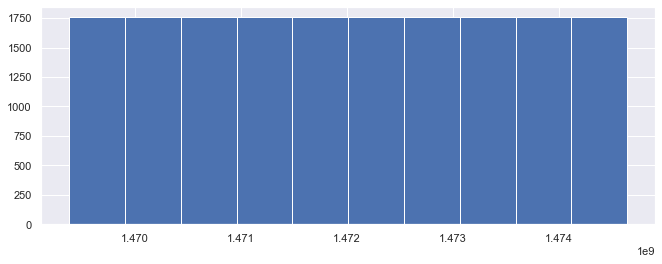

In [11]:
cpu_data.timestamp.hist()

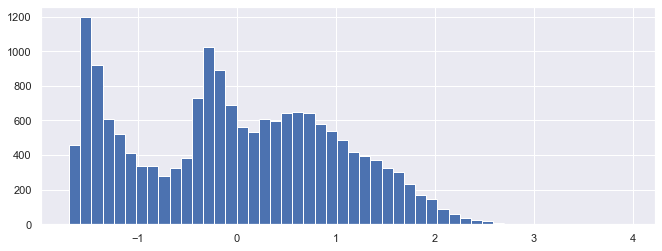

In [12]:
cpu_data.value.hist(bins=50)

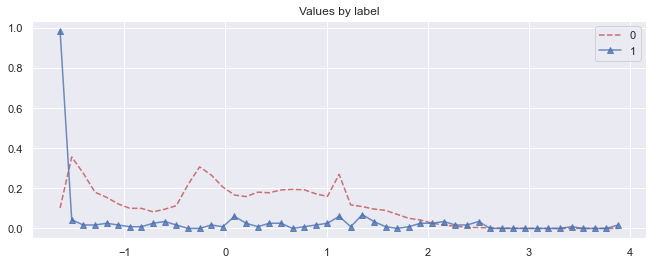

In [47]:
import numpy as np
from matplotlib import pyplot as plt

markers = ['r--', 'b-^']

def hist2d(X, by_col, n_bins=10, title=None):
  '''plot two histograms against each other.

  I am using line plots here. Alternatively, 
  we could be using hist() with opacity.
  '''
  bins = np.linspace(X.min(), X.max(), n_bins)
  
  vals = np.unique(by_col)
  for marker, val in zip(markers, vals):
    n, edges = np.histogram(X[by_col==val], bins=bins)
    n = n / np.linalg.norm(n)
    bin_centers = 0.5 * (edges[1:] + edges[:-1])
    plt.plot(bin_centers, n, marker, alpha=0.8, label=val)

  plt.legend(loc='upper right')
  if title is not None:
    plt.title(title)
  plt.show()

hist2d(cpu_data.value, cpu_data.label, n_bins=50, title='Values by label')

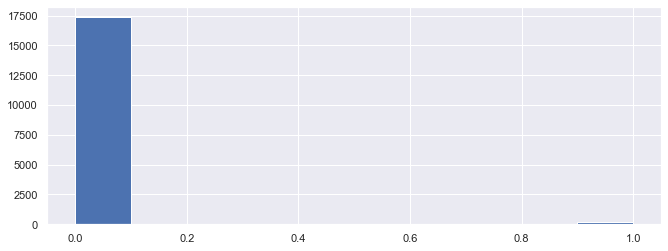

In [48]:
cpu_data.label.hist()

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(cpu_data[['value']].values, cpu_data.label.values)

In [51]:
X_test.shape

(4392, 1)

In [52]:
# simplest example from the docs: train kNN detector
from pyod.models.knn import KNN
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores


In [53]:
from pyod.utils.data import evaluate_print
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)



On Training Data:
KNN ROC:0.5064, precision @ rank n:0.2857

On Test Data:
KNN ROC:0.5085, precision @ rank n:0.3333


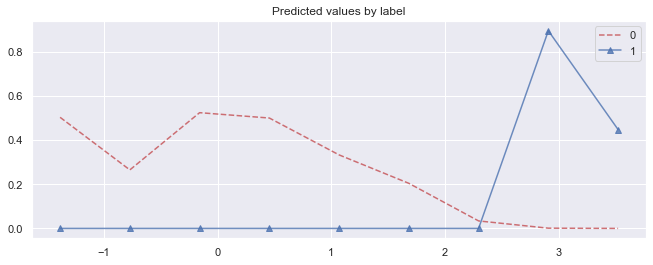

In [54]:
hist2d(X_test, y_test_pred, title='Predicted values by label')

Since this is prototype-based, it's not too surprising that this detector doesn't find any outlier: all points are similar to points shown before.

Let's show only examples that are not outliers. Let's also package this up a bit.

In [55]:
X_train[y_train==0.0].shape

(13024, 1)

In [56]:
X_train.shape

(13176, 1)

In [57]:
y_train.sum()

152

In [58]:
from pyod.utils.data import evaluate_print


def test_outlier_detector(X_train, y_train,
                          X_test, y_test, only_neg=True,
                          basemethod=KNN()):
  '''Test an outlier detection method on a dataset.
  This function trains a model, get performance metrics of
  the model, and plots a visualization.

  Parameters:
  -----------
  X_train : training features
  y_train : training labels
  X_test : test features
  y_test : test labels
  only_neg : whether to use only normal (i.e. not outliers) for training
  basemethod : the model to test
  '''

  clf = basemethod
  if only_neg:
    clf.fit(X_train[y_train==0.0], np.zeros(shape=((y_train==0.0).sum(), 1)))
  else:
    clf.fit(X_train, y_train)  # most algorithms ignore y

  y_train_pred = clf.predict(X_train)  # labels_
  y_train_scores = clf.decision_scores_

  y_test_pred = clf.predict(X_test)
  y_test_scores = clf.decision_function(X_test)

  print("\nOn Test Data:")
  evaluate_print(type(clf).__name__, y_test, y_test_scores)
  hist2d(X_test, y_test_pred, title='Predicted values by label')

/Users/ben/anaconda3/lib/python3.6/site-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")



On Test Data:
KNN ROC:0.5085, precision @ rank n:0.3333


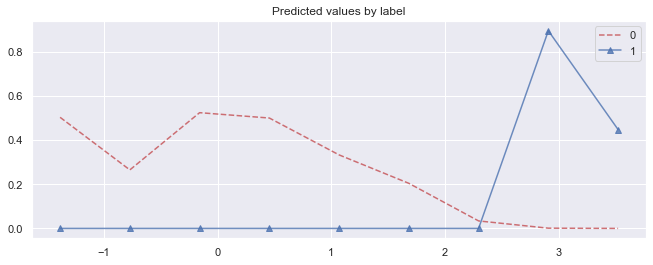

In [59]:
test_outlier_detector(X_train, y_train, X_test, y_test, only_neg=False, basemethod=KNN(n_neighbors=3, metric='hamming', method='mean', contamination=0.01))

In [62]:
from pyod.models.auto_encoder import AutoEncoder

type(AutoEncoder(hidden_neurons=[1], epochs=10)).__name__

'AutoEncoder'





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/Users/ben/anaconda3/lib/python3.6/site-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2         
Total para

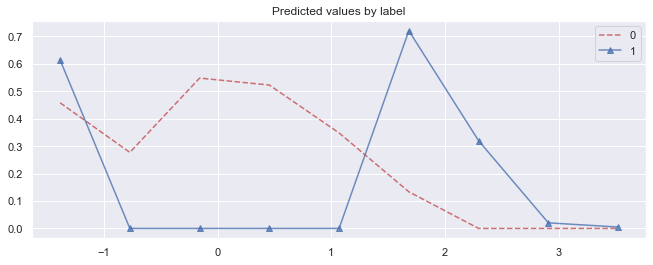

In [63]:
test_outlier_detector(
    X_train, y_train, X_test, y_test, 
    only_neg=False, basemethod=AutoEncoder(hidden_neurons=[1], epochs=10)
)

/Users/ben/anaconda3/lib/python3.6/site-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 2         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2         
Total para

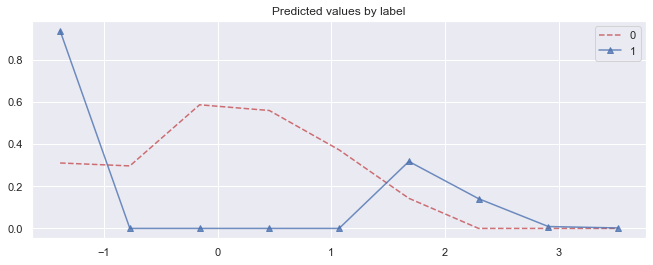

In [64]:
test_outlier_detector(
    X_train, y_train, X_test, y_test, 
    only_neg=True, basemethod=AutoEncoder(hidden_neurons=[1], epochs=10)
)



We didn't manage to get the KNN algorithm to work with our dataset, however, the autoencoder seems to work quite nicely, even though it incorrectly flags values in the upper range as well as in the lower range as we'd hoped.

/Users/ben/anaconda3/lib/python3.6/site-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")



On Test Data:
LOF ROC:0.5088, precision @ rank n:1.0


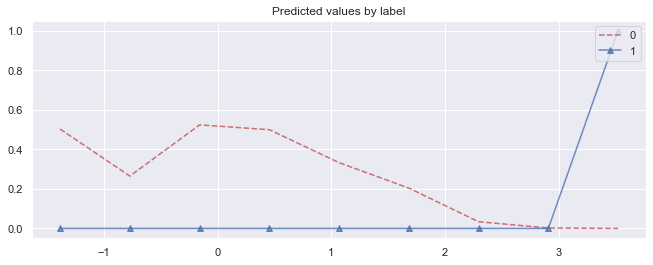

In [65]:
from pyod.models.lof import LOF

test_outlier_detector(
    X_train, y_train, X_test, y_test, 
    only_neg=False, basemethod=LOF(n_neighbors=2, contamination=0.01),
)

/Users/ben/anaconda3/lib/python3.6/site-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")



On Test Data:
IForest ROC:0.8598, precision @ rank n:0.0962


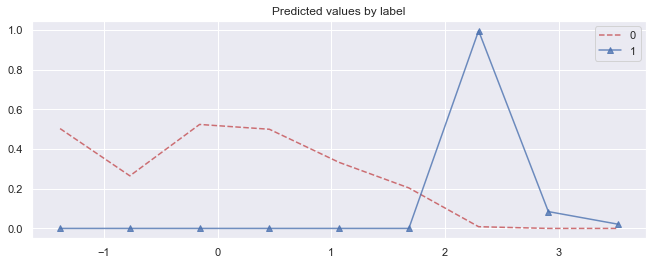

In [66]:
from pyod.models.iforest import IForest

test_outlier_detector(
    X_train, y_train, X_test, y_test, 
    only_neg=True, basemethod=IForest(contamination=0.01),
)

Many implementations for outlier detections are publicly available for python:

* As part of Numenta's [Cortical Learning Algorithm](http://nupic.docs.numenta.org/stable/guides/anomaly-detection.html#temporalanomaly-model)
* [Banpei](https://github.com/tsurubee/banpei) - singular spectrum transformation
* [Deep Anomaly Detection Methods for Time Series](https://github.com/KDD-OpenSource/DeepADoTS)
* [Telemanom](https://github.com/khundman/telemanom) - LSTMs for multivariate time-series data
* [DONUT](https://github.com/haowen-xu/donut) - Variational Auto-Encoder for Seasonal KPIs

A fantastic resource for [material about outlier detection](https://github.com/yzhao062/anomaly-detection-resources) is the PyOD author's dedicated repository.

